In [ ]:
!pip install torchinfo
!pip install torchmetrics
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

# <b>1 <span style='color:#9146ff'>|</span> Import Libraries</b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import wandb

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchinfo import summary
from torchmetrics.text import BLEUScore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import seaborn as sns


import re
import ast
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
from wordcloud import WordCloud



In [ ]:
# Convert to DataFrame
data = pd.DataFrame(pd.read_json('/content/Cleaned_date.json'))
df_cleaned = (data)

df_cleaned = df_cleaned.drop(columns=['input', 'text'])

# Display the result
df_cleaned

,instruction,output
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is..."
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inve..."
3,Specifically when do options expire?,"Equity options, at least those traded in the A..."
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ..."
...,...,...
68907,Generate an example of what a resume should li...,"Jean Tremaine\n1234 Main Street, Anytown, CA 9..."
68908,Arrange the items given below in the order to ...,I eating cake.
68909,Write an introductory paragraph about a famous...,Michelle Obama is an inspirational woman who r...
68910,Generate a list of five things one should keep...,1. Research potential opportunities and carefu...


In [ ]:
df = df_cleaned
df.head(10)

,instruction,output
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is..."
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inve..."
3,Specifically when do options expire?,"Equity options, at least those traded in the A..."
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ..."
5,Approximation of equity value for company in d...,"Generally ""default"" means that the company can..."
6,Is it true that 90% of investors lose their mo...,The game is not zero sum. When a friend and I ...
7,Can a company charge you for services never re...,"In general, you can only be charged for servic..."
8,Working out if I should be registered as self-...,Being self employed just means you fill out so...
9,About eToro investments,"For eToro, just like any other brokerage firm,..."


# <b>2 <span style='color:#9146ff'>|</span> Dataset</b>

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


### Define dataframe

In [ ]:
#df_cleaned['output'] = [x[:19] for x in df_cleaned['output']]
df_cleaned['output'] = df_cleaned['output'].apply(lambda x: ' '.join(x.split()[:20]))
df_cleaned

,instruction,output
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is..."
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inves..."
3,Specifically when do options expire?,"Equity options, at least those traded in the A..."
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ..."
...,...,...
68907,Generate an example of what a resume should li...,"Jean Tremaine 1234 Main Street, Anytown, CA 98..."
68908,Arrange the items given below in the order to ...,I eating cake.
68909,Write an introductory paragraph about a famous...,Michelle Obama is an inspirational woman who r...
68910,Generate a list of five things one should keep...,1. Research potential opportunities and carefu...


In [ ]:
df['src_len'] = [len(text.split()) for text in df.instruction]
df['trg_len'] = [len(text.split()) for text in df.output]


# <b>4 <span style='color:#9146ff'>|</span> Data processing</b>

### Define functions to treat dialog and answer columns

In [ ]:
def dialog_treatment(df,column):
    df[column] = df[column].astype(str) # Convert all the values of the column to str type
    df[column] = df[column].str.lower() # Transform the string values in lowercase
    df[column] = df[column].apply(lambda x: re.sub("[^A-Za-z\s]","",x)) # Replace any non-alphabetical characters with white space
    df[column] = df[column].apply(lambda x: x.replace("\s+"," ")) # Replace white spaces with a single white space
    df[column] = df[column].apply(lambda x: " ".join([word for word in x.split()])) ###'''
    return df

def answer_treatment(df,column):
    df[column] = df[column].astype(str) # Convert all the values of the column to str type
    df[column] = df[column].str.lower() # Transform the string values in lowercase
    df[column] = df[column].apply(lambda x: re.sub(r'\d','',x))# Remove all numeric characters
    df[column] = df[column].apply(lambda x: x.replace("\s+"," ")) # Replace white spaces with a single white space
    df[column] = df[column].apply(lambda x: re.sub(r"[-()&\"#/@;:<>{}`+=~|.!?,।]", "", x)) # Remove specific punctuation and special characters from the values
    df[column] = df[column].apply(lambda x: x.strip()) # Clean up text data  removing unwanted spaces'''
    df[column] = "<sos> " + df[column] + " <eos>" # Add start of sequence and end of sequence to the string
    return df

### Treat columns

In [ ]:
df = dialog_treatment(df , 'instruction')
df = answer_treatment(df , 'output')

### Define the max and minimum length of a sentence in each column

In [ ]:
src_max_lenght_sentence = np.max(df['src_len'])
trg_max_lenght_sentence = np.max(df['trg_len'])

In [ ]:
import numpy as np
from collections import Counter

class SimpleTokenizer:
    def __init__(self, num_words=None, oov_token="<OOV>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_counts = Counter()
        self.word_index = {}
        self.index_word = {}
        self.fitted = False

    def fit_on_texts(self, texts):
        for text in texts:
            self.word_counts.update(text.split())

        # Include <pad> and <OOV>
        vocab = [self.oov_token] + [word for word, _ in self.word_counts.most_common(self.num_words)]
        vocab = ['<pad>'] + vocab

        self.word_index = {word: idx for idx, word in enumerate(vocab)}
        self.index_word = {idx: word for word, idx in self.word_index.items()}
        self.fitted = True

    def texts_to_sequences(self, texts):
        if not self.fitted:
            raise ValueError("Tokenizer has not been fitted yet.")
        sequences = []
        for text in texts:
            sequence = [self.word_index.get(word, self.word_index[self.oov_token]) for word in text.split()]
            sequences.append(sequence)
        return sequences

def Vectorization(column, max_sequence_length):
    global df

    sentences = df[column].tolist()

    tokenizer = SimpleTokenizer()
    tokenizer.fit_on_texts(sentences)

    sequences = tokenizer.texts_to_sequences(sentences)


    pad_sequen = []
    for seq in sequences:
        if len(seq) < max_sequence_length:
            seq = seq + [tokenizer.word_index['<pad>']] * (max_sequence_length - len(seq))
        else:
            seq = seq[:max_sequence_length]
        pad_sequen.append(seq)

    pad_sequen = np.array(pad_sequen, dtype=np.int32)

    print(pad_sequen)
    print(tokenizer.word_index)

    return pad_sequen, tokenizer

In [ ]:
src_sequences, src_tokenizer = Vectorization('instruction', src_max_lenght_sentence)
trg_sequences, trg_tokenizer = Vectorization('output', trg_max_lenght_sentence)

[[   7    3  112 ...    0    0    0]
 [  33   55   22 ...    0    0    0]
 [ 162   45   18 ...    0    0    0]
 ...
 [  28   10 3910 ...    0    0    0]
 [  17    3   21 ...    0    0    0]
 [ 156    2   11 ...    0    0    0]]
{'<pad>': 0, '<OOV>': 1, 'the': 2, 'a': 3, 'of': 4, 'to': 5, 'in': 6, 'for': 7, 'and': 8, 'is': 9, 'an': 10, 'given': 11, 'following': 12, 'sentence': 13, 'what': 14, 'that': 15, 'how': 16, 'generate': 17, 'i': 18, 'with': 19, 'create': 20, 'list': 21, 'it': 22, 'on': 23, 'describe': 24, 'can': 25, 'are': 26, 'about': 27, 'write': 28, 'or': 29, 'this': 30, 'two': 31, 'from': 32, 'why': 33, 'explain': 34, 'do': 35, 'my': 36, 'name': 37, 'you': 38, 'words': 39, 'using': 40, 'be': 41, 'find': 42, 'three': 43, 'make': 44, 'should': 45, 'stock': 46, 'as': 47, 'identify': 48, 'into': 49, 'between': 50, 'story': 51, 'word': 52, 'one': 53, 'if': 54, 'does': 55, 'new': 56, 'five': 57, 'rewrite': 58, 'text': 59, 'when': 60, 'money': 61, 'by': 62, 'up': 63, 'provide': 64, 

In [ ]:
src_sequences , src_tokenizer = Vectorization('instruction' , src_max_lenght_sentence)
trg_sequences , trg_tokenizer = Vectorization('output' , trg_max_lenght_sentence)

[[   7    3  112 ...    0    0    0]
 [  33   55   22 ...    0    0    0]
 [ 162   45   18 ...    0    0    0]
 ...
 [  28   10 3910 ...    0    0    0]
 [  17    3   21 ...    0    0    0]
 [ 156    2   11 ...    0    0    0]]
{'<pad>': 0, '<OOV>': 1, 'the': 2, 'a': 3, 'of': 4, 'to': 5, 'in': 6, 'for': 7, 'and': 8, 'is': 9, 'an': 10, 'given': 11, 'following': 12, 'sentence': 13, 'what': 14, 'that': 15, 'how': 16, 'generate': 17, 'i': 18, 'with': 19, 'create': 20, 'list': 21, 'it': 22, 'on': 23, 'describe': 24, 'can': 25, 'are': 26, 'about': 27, 'write': 28, 'or': 29, 'this': 30, 'two': 31, 'from': 32, 'why': 33, 'explain': 34, 'do': 35, 'my': 36, 'name': 37, 'you': 38, 'words': 39, 'using': 40, 'be': 41, 'find': 42, 'three': 43, 'make': 44, 'should': 45, 'stock': 46, 'as': 47, 'identify': 48, 'into': 49, 'between': 50, 'story': 51, 'word': 52, 'one': 53, 'if': 54, 'does': 55, 'new': 56, 'five': 57, 'rewrite': 58, 'text': 59, 'when': 60, 'money': 61, 'by': 62, 'up': 63, 'provide': 64, 

In [ ]:
print("Size of the source vocabulary :",len(src_tokenizer.word_index))
print("Size of the target vocabulary :", len(trg_tokenizer.word_index))

Size of the source vocabulary : 16864
Size of the target vocabulary : 39912


### Verify sequence tokenized

In [ ]:
trg_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in trg_sequences[6] if idx != 0])
print(f"{trg_sequences[6]} \n\n {trg_sent}")

[   2    4  316    9   31 1513  580   42    5  526    8   16 7963  192
    5  635    8  761    5  261] 

 <sos> the game is not zero sum when a friend and i chop down a tree and build a house


# <b>5 <span style='color:#9146ff'>|</span> Data Pipeline</b>

In [ ]:
batch_size = 128


dataset = TensorDataset(torch.LongTensor(src_sequences) , torch.LongTensor(trg_sequences)) # Converts sequences in Pytoch tensors and create a tensor dataset

torch.manual_seed(42)

dataframe_dataloader = DataLoader(
    dataset = dataset ,
    batch_size = batch_size ,
    shuffle = True ,
    num_workers = 4 ,
    pin_memory = True
)

# <b>6 <span style='color:#9146ff'>|</span> Model Build </b>

## <b>6.1 <span style='color:#9146ff'> Self-Attention</span>  </b>
It let's the model decide how important each part of an input sequence is, which makes it possible to find dependencies and connections in the data.

The model calculates the attention weights between each element in the input sequence, allowing it to focus on the relevant factors.

In [ ]:
def SelfAttention(q , k , v , mask) :

    attention_scores = torch.matmul(q , k.transpose(-2 , -1)).to(DEVICE)  # Matrix multiplication

    scaling = torch.sqrt(torch.tensor(k.size(-1) , dtype = torch.float32)).to(DEVICE) # Computes the square root of dim

    scaled_attention = attention_scores / scaling

    # Apply mask if provided (useful for preventing attention to certain parts like padding)
    if mask is not None:
        scaled_attention += (mask * -1e9)

    # Apply softmax
    attention_weights = torch.softmax(scaled_attention, dim=-1).to(DEVICE)

    # Compute the weighted sum of the value vectors using the attention weights
    output = torch.matmul(attention_weights , v).to(DEVICE)

    return output

## <b>6.2 <span style='color:#9146ff'> Multi-Head-Attention</span>  </b>

In [ ]:
class MultiHeadAttention(nn.Module) :
    def __init__(self , model_dimension , num_heads) :
        super(MultiHeadAttention , self).__init__()

        self.model_dimension = model_dimension
        self.num_heads = num_heads

        # Verify if the model dimension is divisible by num_head
        assert self.model_dimension % self.num_heads == 0

        self.head_dimension = self.model_dimension // self.num_heads # Dimension of each head's key, query, and value

        # Linear layers for input transformations
        self.Q = nn.Linear(model_dimension , model_dimension) # Query
        self.K = nn.Linear(model_dimension , model_dimension) # Key
        self.V = nn.Linear(model_dimension , model_dimension) # Value
        self.output_t = nn.Linear(model_dimension , model_dimension) # Output

    def split_heads(self , x , batch_size) :

        # Change the input to have the num_heads for multi-head attention
        x = x.reshape(batch_size , -1 , self.num_heads , self.head_dimension)
        return x.permute(0, 2, 1, 3)

    def forward(self , q , k , v , mask = None) :
        batch_size = q.shape[0]

        # Apply linear transformations and split heads
        q_transform = self.split_heads(self.Q(q),batch_size)
        k_transform = self.split_heads(self.K(k),batch_size)
        v_transform = self.split_heads(self.V(v),batch_size)

        # Perform scaled dot-product attention
        self_attention = SelfAttention(q_transform , k_transform , v_transform , mask)

        # Rearrange shape
        self_attention =  self_attention.permute(0 , 2 , 1 , 3)

        # Concatenation of heads
        attention_output = self_attention.reshape(batch_size, -1, self.model_dimension)

        output = self.output_t(attention_output)

        return output

# <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.3-</b> Encoder</span>
The encoder takes in a sequence of tokens and produces a fixed-size vector representation of the entire sequence, which can then be used for classification.

In [ ]:
class EncoderLayer(nn.Module) :
    def __init__(self , model_dimension , num_heads , inner_layer_dimension , dropout_rate = 0.1) :
        super(EncoderLayer , self).__init__()
        self.multi_head_attention = MultiHeadAttention(model_dimension , num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm2 = nn.LayerNorm(model_dimension, eps=1e-6)

        # Dropout rate  for regularization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.feed_foward_network = nn.Sequential(
            nn.Linear(model_dimension , inner_layer_dimension),
            nn.ReLU(),
            nn.Linear(inner_layer_dimension , model_dimension))

    def forward(self , x , mask) :

        # X is passed through the multi-head mechanism
        attn_output =self.multi_head_attention(x , x , x , mask)

        # Dropout to prevent overfitting
        attn_output = self.dropout1(attn_output)

        # Normalization
        out1 = self.norm1(x + attn_output)

        feed_foward_output = self.dropout2(self.feed_foward_network(out1))

        encoder_output = self.norm2(out1 + feed_foward_output)

        return encoder_output

In [ ]:
class Encoder(nn.Module) :
    def __init__(self, num_layers ,model_dimension, num_heads, inner_layer_dimension ,src_vocab_size,max_length,dropout_rate = 0.1):
        super(Encoder , self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(src_vocab_size , model_dimension)

        self.encoding_transformation = nn.Embedding(max_length , model_dimension)

        self.encoder_layers = [EncoderLayer(model_dimension , num_heads , inner_layer_dimension , dropout_rate).to(DEVICE) for _ in range(num_layers)]

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self , x , mask) :
        batch_size , seqlen = x.shape # # Unpacking  shape

        # Generates a 1D tensor containing integers from 0 to seqlen-1, replicates this sequence for each item in the batch
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)

        output = self.dropout((self.embedding(x) + self.encoding_transformation(positions)))

        for i in range(self.num_layers) :
            output = self.encoder_layers[i](output , mask)

        return output

## <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.4-</b> Decoder</span>

In [ ]:
class DecoderLayer(nn.Module) :
    def __init__(self , model_dimension , num_heads , inner_layer_dimension , dropout_rate = 0.1) :
        super(DecoderLayer , self).__init__()

        self.self_attn = MultiHeadAttention(model_dimension , num_heads)

        # Multi-head attention mechanism that attends to the encoder's output

        self.cross_attn = MultiHeadAttention(model_dimension , num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm2 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm3 = nn.LayerNorm(model_dimension , eps=1e-6)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.feed_forward_network = nn.Sequential( ######
            nn.Linear(model_dimension, inner_layer_dimension),
            nn.ReLU() ,
            nn.Linear(inner_layer_dimension, model_dimension))

    def forward(self , x , enc_output , src_mask , padding_mask) :

        attention_output = self.self_attn(x , x , x , src_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.norm1(attention_output  + x)

        attn2 = self.cross_attn(out1 , enc_output , enc_output , padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(attn2 + out1)

        ff_output = self.dropout3(self.feed_forward_network(out2))
        decoder_output = self.norm3(ff_output + out2)

        return decoder_output

In [ ]:
class Decoder(nn.Module) :
    def __init__(self,num_layers , model_dimension, num_heads, inner_layer_dimension, trg_vocab_size,max_length, dropout_rate = 0.1):

        super(Decoder , self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(trg_vocab_size , model_dimension)

        self.pos_encoding = nn.Embedding(max_length , model_dimension)

        self.decoder_layers = [DecoderLayer(model_dimension , num_heads , inner_layer_dimension, dropout_rate).to(DEVICE) for _ in range(num_layers)]

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self , x , encoder_output, src_mask , padding_mask) : ########
        batch_size , seqlen = x.shape

        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)

        output = self.dropout((self.embedding(x) + self.pos_encoding(positions)))

        # Applies each decoder layer sequentially to the output of the previous layer
        for i in range(self.num_layers) : output  = self.decoder_layers[i](output , encoder_output , src_mask , padding_mask)

        return output

## <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.4-</b> Transformer</span>

In [ ]:
class Transformer(nn.Module) :
    def __init__(self,num_layers,embedding_dim,num_heads,inner_layer_dimension,src_vocab_size,trg_vocab_size,src_max_length,trg_max_length ,dropout_rate = 0.1) :

        super(Transformer , self).__init__()

        self.encoder = Encoder(num_layers,model_dimension,num_heads,inner_layer_dimension, src_vocab_size,src_max_length,dropout_rate).to(DEVICE)

        self.decoder = Decoder(num_layers,model_dimension,num_heads,inner_layer_dimension,trg_vocab_size,trg_max_length,dropout_rate).to(DEVICE)

        # Fully connected linear layer mapping to target vocabulary size
        self.fc_out = nn.Linear(model_dimension , trg_vocab_size)

    def define_mask(self , seq) :
        # Ensure that padding tokens are ignored and that future tokens are not visible during training for the target sequence.

        sequence_mask = (seq == 0).float().unsqueeze(1).unsqueeze(2)

        return sequence_mask


    def look_ahead_mask(self , trg) :
        # The look-ahead mask is used to mask the future tokens in a sequence.

        batch_size , trg_len = trg.shape

        trg_mask = 1 - torch.tril(torch.ones((trg_len , trg_len)), diagonal=0).expand(
            batch_size, 1, trg_len, trg_len
        )

        return trg_mask

    def create_masks(self , src , trg) :

        # Encoder padding mask
        encoder_padding_mask = self.define_mask(src).to(DEVICE)

        # Decoder padding mask
        decoder_padding_mask = self.define_mask(src).to(DEVICE)

        look_ahead_mask = self.look_ahead_mask(trg).to(DEVICE)

        decoder_trg_padding_mask = self.define_mask(trg).to(DEVICE)

        combined_mask = torch.max(decoder_trg_padding_mask , look_ahead_mask).to(DEVICE)

        return encoder_padding_mask , combined_mask , decoder_padding_mask

    def forward(self , src , trg) :

        encoder_padding_mask , look_ahead_mask , decoder_padding_mask = self.create_masks(src , trg)

        encoder_output = self.encoder(src , encoder_padding_mask)

        decoder_output = self.decoder(trg , encoder_output , look_ahead_mask, decoder_padding_mask)

        output = self.fc_out(decoder_output)

        return output

## Define hyperparameters

In [ ]:
epochs = 80
lr = 5e-4   # Learning rate
model_dimension = 256
inner_layer_dimension = 512
num_layers = 4
num_heads = 8
dropout_rate = 0.1
src_vocab_size = len(src_tokenizer.word_index) # Vocabulary size for source
trg_vocab_size = len(trg_tokenizer.word_index) # Vocabulary size for target
src_max_len = np.max(df['src_len'])
trg_max_len = np.max(df['trg_len'])

model = Transformer(num_layers,model_dimension,num_heads,inner_layer_dimension,src_vocab_size,trg_vocab_size,src_max_len, trg_max_len,dropout_rate).to(DEVICE)

# <b>7 <span style='color:#9146ff'>|</span> Train model </b>

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=src_tokenizer.word_index['<pad>'])
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
def train_step(src , trg) :

    decoder_input = trg[: , :-1]

    trg_reals = trg[: , 1:].reshape(-1)

    preds = model(src , decoder_input)

    preds = preds.reshape(-1 , preds.shape[2])

    optimizer.zero_grad()

    loss = criterion(preds , trg_reals)

    loss.backward()

    # Avoid exploding gradient issues
    torch.nn.utils.clip_grad_norm_(model.parameters() , max_norm=1)

    optimizer.step()

    return loss

In [ ]:
import torch
import wandb
from tqdm import tqdm
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset


dataset_size = len(dataframe_dataloader.dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

# Split the dataset indices
indices = list(range(dataset_size))
train_indices, val_indices = random_split(indices, [train_size, val_size])

# Create Subset instances for training and validation
train_dataset = Subset(dataframe_dataloader.dataset, train_indices)
val_dataset = Subset(dataframe_dataloader.dataset, val_indices)

# Create DataLoaders for train and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Start a new wandb run to track this script.
run = wandb.init(
    entity="lorrayne-reis-silva-city-university-of-london",
    project="transformers_encoder_decoder_5_final",
    config={
        "architecture": "encoder_decoder_transformers",
        "dataset": "investment_dataset",
        "epochs": 80,
    },
)

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    epoch_train_loss = 0
    epoch_val_loss = 0

    # Train phase
    model.train()
    for src, trg in train_dataloader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        loss = train_step(src, trg)  # Assume train_step() returns the loss
        epoch_train_loss += loss

    # Calculate average training loss and train perplexity
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss.cpu().detach().numpy())
    train_perplexity = np.exp(avg_train_loss.cpu().item())  # Calculate training perplexity

    # Validation phase
    model.eval()
    with torch.no_grad(): # Context manager to disable gradient calculation during validation
        for src, trg in val_dataloader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            # Get model predictions
            decoder_input = trg[:, :-1]
            trg_reals = trg[:, 1:].reshape(-1)
            preds = model(src, decoder_input)
            preds = preds.reshape(-1, preds.shape[2])

            # Calculate validation loss
            loss_val = criterion(preds, trg_reals)
            epoch_val_loss += loss_val

    # Calculate average validation loss and validation perplexity
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss.cpu().detach().numpy()) # Store validation loss
    val_perplexity = np.exp(avg_val_loss.cpu().item())  # Calculate validation perplexity


     # Logging
    if (epoch + 1) % 1 == 0:
        print(f"\n[Epoch: {epoch+1}/{epochs}] "
              f"[Train Loss: {train_losses[-1]:0.2f}] "
              f"[Train Perplexity: {train_perplexity:0.2f}] \n")

        # Log to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "train_perplexity": train_perplexity
        })

model_path = "trained_model_MHA.pt"
torch.save(model.state_dict(), model_path)

model_artifact = wandb.Artifact(
    name="transformers_encoder_decoder_5_final",
    type="model",
    description="Transformer encoder-decoder model Talking Head trained on investment dataset",
    metadata={
        "architecture": "encoder_decoder_transformers_mqa_talking_head",
        "dataset": "investment_dataset",
        "epochs": epochs,
        "batch_size": 32,
        "learning_rate": 5e-4,
        "droput_rate": 0.1,
    }
)

model_artifact.add_file(model_path)


run.log_artifact(model_artifact)

run.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lorrayne-reis-silva (lorrayne-reis-silva-city-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  1%|▏         | 1/80 [01:18<1:42:45, 78.05s/it]


[Epoch: 1/80] [Train Loss: 6.84] [Train Perplexity: 936.18] 



  2%|▎         | 2/80 [02:35<1:41:00, 77.69s/it]


[Epoch: 2/80] [Train Loss: 5.99] [Train Perplexity: 399.44] 



  4%|▍         | 3/80 [03:51<1:38:42, 76.91s/it]


[Epoch: 3/80] [Train Loss: 5.59] [Train Perplexity: 266.61] 



  5%|▌         | 4/80 [05:07<1:36:51, 76.47s/it]


[Epoch: 4/80] [Train Loss: 5.30] [Train Perplexity: 199.39] 



  6%|▋         | 5/80 [06:24<1:35:54, 76.72s/it]


[Epoch: 5/80] [Train Loss: 5.07] [Train Perplexity: 158.59] 



  8%|▊         | 6/80 [07:44<1:36:04, 77.90s/it]


[Epoch: 6/80] [Train Loss: 4.88] [Train Perplexity: 131.53] 



  9%|▉         | 7/80 [09:01<1:34:31, 77.69s/it]


[Epoch: 7/80] [Train Loss: 4.72] [Train Perplexity: 112.47] 



 10%|█         | 8/80 [10:18<1:32:40, 77.23s/it]


[Epoch: 8/80] [Train Loss: 4.59] [Train Perplexity: 98.42] 



 11%|█▏        | 9/80 [11:34<1:31:06, 77.00s/it]


[Epoch: 9/80] [Train Loss: 4.48] [Train Perplexity: 87.92] 



 12%|█▎        | 10/80 [12:50<1:29:33, 76.76s/it]


[Epoch: 10/80] [Train Loss: 4.37] [Train Perplexity: 79.41] 



 14%|█▍        | 11/80 [14:07<1:28:06, 76.62s/it]


[Epoch: 11/80] [Train Loss: 4.28] [Train Perplexity: 72.59] 



 15%|█▌        | 12/80 [15:23<1:26:49, 76.61s/it]


[Epoch: 12/80] [Train Loss: 4.21] [Train Perplexity: 67.03] 



 16%|█▋        | 13/80 [16:40<1:25:31, 76.59s/it]


[Epoch: 13/80] [Train Loss: 4.13] [Train Perplexity: 62.30] 



 18%|█▊        | 14/80 [17:57<1:24:21, 76.69s/it]


[Epoch: 14/80] [Train Loss: 4.06] [Train Perplexity: 58.14] 



 19%|█▉        | 15/80 [19:13<1:23:06, 76.72s/it]


[Epoch: 15/80] [Train Loss: 4.00] [Train Perplexity: 54.69] 



 20%|██        | 16/80 [20:30<1:21:49, 76.72s/it]


[Epoch: 16/80] [Train Loss: 3.94] [Train Perplexity: 51.55] 



 21%|██▏       | 17/80 [21:47<1:20:31, 76.69s/it]


[Epoch: 17/80] [Train Loss: 3.89] [Train Perplexity: 48.89] 



 22%|██▎       | 18/80 [23:03<1:19:13, 76.67s/it]


[Epoch: 18/80] [Train Loss: 3.84] [Train Perplexity: 46.41] 



 24%|██▍       | 19/80 [24:20<1:17:55, 76.64s/it]


[Epoch: 19/80] [Train Loss: 3.79] [Train Perplexity: 44.40] 



 25%|██▌       | 20/80 [25:37<1:16:46, 76.77s/it]


[Epoch: 20/80] [Train Loss: 3.75] [Train Perplexity: 42.38] 



 26%|██▋       | 21/80 [26:54<1:15:25, 76.71s/it]


[Epoch: 21/80] [Train Loss: 3.71] [Train Perplexity: 40.69] 



 28%|██▊       | 22/80 [28:10<1:14:09, 76.72s/it]


[Epoch: 22/80] [Train Loss: 3.66] [Train Perplexity: 39.01] 



 29%|██▉       | 23/80 [29:27<1:12:49, 76.66s/it]


[Epoch: 23/80] [Train Loss: 3.63] [Train Perplexity: 37.57] 



 30%|███       | 24/80 [30:43<1:11:30, 76.61s/it]


[Epoch: 24/80] [Train Loss: 3.59] [Train Perplexity: 36.26] 



 31%|███▏      | 25/80 [32:00<1:10:18, 76.70s/it]


[Epoch: 25/80] [Train Loss: 3.56] [Train Perplexity: 35.06] 



 32%|███▎      | 26/80 [33:18<1:09:23, 77.11s/it]


[Epoch: 26/80] [Train Loss: 3.52] [Train Perplexity: 33.93] 



 34%|███▍      | 27/80 [34:36<1:08:11, 77.19s/it]


[Epoch: 27/80] [Train Loss: 3.49] [Train Perplexity: 32.91] 



 35%|███▌      | 28/80 [35:52<1:06:42, 76.98s/it]


[Epoch: 28/80] [Train Loss: 3.46] [Train Perplexity: 31.93] 



 36%|███▋      | 29/80 [37:09<1:05:17, 76.81s/it]


[Epoch: 29/80] [Train Loss: 3.44] [Train Perplexity: 31.04] 



 38%|███▊      | 30/80 [38:26<1:04:09, 77.00s/it]


[Epoch: 30/80] [Train Loss: 3.41] [Train Perplexity: 30.22] 



 39%|███▉      | 31/80 [39:43<1:02:47, 76.88s/it]


[Epoch: 31/80] [Train Loss: 3.38] [Train Perplexity: 29.41] 



 40%|████      | 32/80 [41:00<1:01:28, 76.85s/it]


[Epoch: 32/80] [Train Loss: 3.36] [Train Perplexity: 28.72] 



 41%|████▏     | 33/80 [42:16<1:00:11, 76.85s/it]


[Epoch: 33/80] [Train Loss: 3.33] [Train Perplexity: 28.03] 



 42%|████▎     | 34/80 [43:33<58:56, 76.89s/it]  


[Epoch: 34/80] [Train Loss: 3.31] [Train Perplexity: 27.39] 



 44%|████▍     | 35/80 [44:51<57:48, 77.08s/it]


[Epoch: 35/80] [Train Loss: 3.29] [Train Perplexity: 26.78] 



 45%|████▌     | 36/80 [46:08<56:26, 76.97s/it]


[Epoch: 36/80] [Train Loss: 3.27] [Train Perplexity: 26.24] 



 46%|████▋     | 37/80 [47:24<55:05, 76.86s/it]


[Epoch: 37/80] [Train Loss: 3.24] [Train Perplexity: 25.66] 



 48%|████▊     | 38/80 [48:41<53:47, 76.85s/it]


[Epoch: 38/80] [Train Loss: 3.23] [Train Perplexity: 25.18] 



 49%|████▉     | 39/80 [49:58<52:26, 76.75s/it]


[Epoch: 39/80] [Train Loss: 3.21] [Train Perplexity: 24.69] 



 50%|█████     | 40/80 [51:14<51:07, 76.69s/it]


[Epoch: 40/80] [Train Loss: 3.19] [Train Perplexity: 24.21] 



 51%|█████▏    | 41/80 [52:31<49:53, 76.76s/it]


[Epoch: 41/80] [Train Loss: 3.17] [Train Perplexity: 23.77] 



 52%|█████▎    | 42/80 [53:48<48:36, 76.74s/it]


[Epoch: 42/80] [Train Loss: 3.15] [Train Perplexity: 23.38] 



 54%|█████▍    | 43/80 [55:05<47:20, 76.77s/it]


[Epoch: 43/80] [Train Loss: 3.14] [Train Perplexity: 22.99] 



 55%|█████▌    | 44/80 [56:21<46:03, 76.76s/it]


[Epoch: 44/80] [Train Loss: 3.12] [Train Perplexity: 22.60] 



 56%|█████▋    | 45/80 [57:38<44:49, 76.83s/it]


[Epoch: 45/80] [Train Loss: 3.10] [Train Perplexity: 22.23] 



 57%|█████▊    | 46/80 [58:55<43:32, 76.83s/it]


[Epoch: 46/80] [Train Loss: 3.09] [Train Perplexity: 21.92] 



 59%|█████▉    | 47/80 [1:00:12<42:15, 76.85s/it]


[Epoch: 47/80] [Train Loss: 3.07] [Train Perplexity: 21.57] 



 60%|██████    | 48/80 [1:01:29<41:02, 76.94s/it]


[Epoch: 48/80] [Train Loss: 3.06] [Train Perplexity: 21.26] 



 61%|██████▏   | 49/80 [1:02:47<39:49, 77.09s/it]


[Epoch: 49/80] [Train Loss: 3.04] [Train Perplexity: 20.95] 



 62%|██████▎   | 50/80 [1:04:04<38:35, 77.18s/it]


[Epoch: 50/80] [Train Loss: 3.03] [Train Perplexity: 20.67] 



 64%|██████▍   | 51/80 [1:05:22<37:23, 77.36s/it]


[Epoch: 51/80] [Train Loss: 3.02] [Train Perplexity: 20.40] 



 65%|██████▌   | 52/80 [1:06:40<36:11, 77.56s/it]


[Epoch: 52/80] [Train Loss: 3.00] [Train Perplexity: 20.11] 



 66%|██████▋   | 53/80 [1:07:57<34:49, 77.38s/it]


[Epoch: 53/80] [Train Loss: 2.99] [Train Perplexity: 19.87] 



 68%|██████▊   | 54/80 [1:09:13<33:24, 77.11s/it]


[Epoch: 54/80] [Train Loss: 2.98] [Train Perplexity: 19.60] 



 69%|██████▉   | 55/80 [1:10:30<32:04, 76.99s/it]


[Epoch: 55/80] [Train Loss: 2.96] [Train Perplexity: 19.34] 



 70%|███████   | 56/80 [1:11:47<30:45, 76.91s/it]


[Epoch: 56/80] [Train Loss: 2.95] [Train Perplexity: 19.13] 



 71%|███████▏  | 57/80 [1:13:04<29:34, 77.14s/it]


[Epoch: 57/80] [Train Loss: 2.94] [Train Perplexity: 18.93] 



 72%|███████▎  | 58/80 [1:14:22<28:20, 77.29s/it]


[Epoch: 58/80] [Train Loss: 2.93] [Train Perplexity: 18.66] 



 74%|███████▍  | 59/80 [1:15:40<27:06, 77.48s/it]


[Epoch: 59/80] [Train Loss: 2.92] [Train Perplexity: 18.45] 



 75%|███████▌  | 60/80 [1:16:57<25:48, 77.40s/it]


[Epoch: 60/80] [Train Loss: 2.90] [Train Perplexity: 18.25] 



 76%|███████▋  | 61/80 [1:18:15<24:34, 77.59s/it]


[Epoch: 61/80] [Train Loss: 2.89] [Train Perplexity: 18.06] 



 78%|███████▊  | 62/80 [1:19:34<23:22, 77.91s/it]


[Epoch: 62/80] [Train Loss: 2.88] [Train Perplexity: 17.87] 



 79%|███████▉  | 63/80 [1:20:51<21:59, 77.63s/it]


[Epoch: 63/80] [Train Loss: 2.87] [Train Perplexity: 17.69] 



 80%|████████  | 64/80 [1:22:08<20:39, 77.48s/it]


[Epoch: 64/80] [Train Loss: 2.86] [Train Perplexity: 17.48] 



 81%|████████▏ | 65/80 [1:23:25<19:20, 77.38s/it]


[Epoch: 65/80] [Train Loss: 2.85] [Train Perplexity: 17.29] 



 82%|████████▎ | 66/80 [1:24:42<18:01, 77.22s/it]


[Epoch: 66/80] [Train Loss: 2.84] [Train Perplexity: 17.15] 



 84%|████████▍ | 67/80 [1:25:59<16:41, 77.07s/it]


[Epoch: 67/80] [Train Loss: 2.83] [Train Perplexity: 16.98] 



 85%|████████▌ | 68/80 [1:27:15<15:23, 76.92s/it]


[Epoch: 68/80] [Train Loss: 2.82] [Train Perplexity: 16.83] 



 86%|████████▋ | 69/80 [1:28:32<14:05, 76.86s/it]


[Epoch: 69/80] [Train Loss: 2.81] [Train Perplexity: 16.66] 



 88%|████████▊ | 70/80 [1:29:49<12:48, 76.88s/it]


[Epoch: 70/80] [Train Loss: 2.80] [Train Perplexity: 16.49] 



 89%|████████▉ | 71/80 [1:31:06<11:31, 76.86s/it]


[Epoch: 71/80] [Train Loss: 2.79] [Train Perplexity: 16.34] 



 90%|█████████ | 72/80 [1:32:22<10:14, 76.82s/it]


[Epoch: 72/80] [Train Loss: 2.78] [Train Perplexity: 16.18] 



 91%|█████████▏| 73/80 [1:33:40<08:58, 76.93s/it]


[Epoch: 73/80] [Train Loss: 2.78] [Train Perplexity: 16.05] 



 92%|█████████▎| 74/80 [1:34:57<07:42, 77.08s/it]


[Epoch: 74/80] [Train Loss: 2.77] [Train Perplexity: 15.89] 



 94%|█████████▍| 75/80 [1:36:14<06:25, 77.14s/it]


[Epoch: 75/80] [Train Loss: 2.76] [Train Perplexity: 15.77] 



 95%|█████████▌| 76/80 [1:37:32<05:09, 77.26s/it]


[Epoch: 76/80] [Train Loss: 2.75] [Train Perplexity: 15.66] 



 96%|█████████▋| 77/80 [1:38:49<03:51, 77.21s/it]


[Epoch: 77/80] [Train Loss: 2.74] [Train Perplexity: 15.50] 



 98%|█████████▊| 78/80 [1:40:06<02:34, 77.15s/it]


[Epoch: 78/80] [Train Loss: 2.73] [Train Perplexity: 15.37] 



 99%|█████████▉| 79/80 [1:41:23<01:17, 77.19s/it]


[Epoch: 79/80] [Train Loss: 2.72] [Train Perplexity: 15.23] 



100%|██████████| 80/80 [1:42:40<00:00, 77.01s/it]


[Epoch: 80/80] [Train Loss: 2.72] [Train Perplexity: 15.13] 



epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▇▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,80
train_loss,2.71681
train_perplexity,15.13198


# <b>8 <span style='color:#9146ff'>|</span> Results </b>

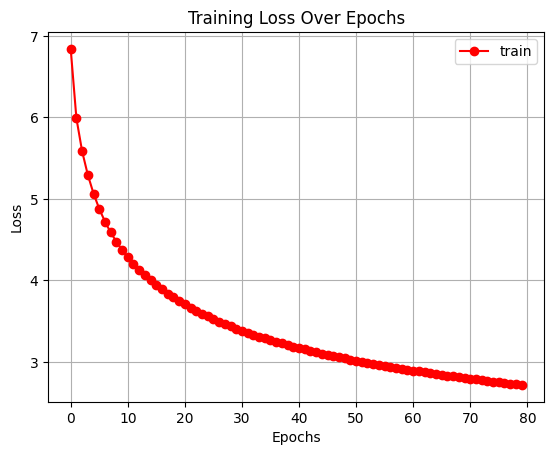

In [ ]:
# Create the plot
plt.plot(train_losses, marker='o', color='red', label='train')

# Add title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()